## Imports

In [2]:
import os
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from IPython.display import display, HTML

### Increase Notebook Display Width

In [3]:
display(HTML("<style>.container {width:90% !important} </style>"))

## Function Definitions

In [4]:
def get_top_terms(text, vectorizer, n=10):
    vectorized = vectorizer.transform([text])

    vectorized_df = pd.DataFrame(vectorized.toarray(), columns=vectorizer.get_feature_names_out())

    non_zero_entries = []
    for column in vectorized_df.columns:
        if vectorized_df[[column]][column][0] > 0:
            non_zero_entries.append(column)

    return ", ".join(vectorized_df[non_zero_entries].transpose().sort_values(by=0, ascending=False).head(n).index)

## Load Annotated Restaurant Dataset

In [5]:
df = pd.read_csv("biel_restaurants_sentiments.csv")
print("Dataset contains {} values".format(len(df)))

Dataset contains 626 values


In [6]:
display(HTML(df.sample(frac=1).to_html()))

,name,review_text,sentiment
470,Restaurant Joran du Port,"Bonjour, Nous avons souper à 4 personnes à la table nous commander 2 portions de filet de perches fris et 2 assiettes de poitrines de poulet . Concernant les filets de perches nous avons reçu une portions avec grossièrement 5 filets complet pour le prix de 25.-, à mon goût , 5.- le filet de perches c’est abusé! Heureusement que nous avions commander une mini portion de frites pour 5,50.-! Pour 30,50.- il n’est pas normal de se lever de table et avoir encore faim! Après réclamation il nous ont offert une troisième portion de filet de perche…… Mais bon a quoi bon! Du côté des poitrines, les deux poulet n’était pas cuit, ça peux arriver, mais ça fait un peu beaucoup! En résumer, je ne conseil pas et je n’y retournerai plus!",negative
33,L'Osteria,"Great Pizza and service, waitress very friendly and attentive. best restaurant in Biel. Building modern and fresh. When ordering Pizza’s you may want to share as they are massive! Great restaurant in the L’Osteria chain!",positive
86,Les Caves,Les Röstis sont exceptionnels! J'y etais il à un an et j'y pense encore! Impatient d'y retourner!,positive
99,Restaurant Räblus,"Auch dieses Mal einfach alles wunderbar, inklusive dem regionalen Wein und überaus gastfreundlich. Danke!",positive
234,Cordon Bleu House,"Personnels très serviable et à l'écoute de nos demandes, la nourriture est de qualité et nourrissante pour conclure c est un bon restaurant pour les grandes occasions ou juste pour un bon repas copieux.",positive
555,L'Osteria,Il y as beaucoup de travaille à faire cette établissement ne représente en aucun cas l italy n'y dans la façon de servir ni dans la façon de la cuisiner je pense que l'établissement prend de haut sa clientèle et beaucoup de menfoutisme et qu'il devait remplacer sonts professionnels dans sont établissements surtout qui parle italiens français et qui souri ........ sa donnerais un peux plus de charme,negative
513,L'Osteria,"Pizza Degli Artisti: Schinken, frische Champigons, Käse, Salami, Paprika, Peperoni, Zwiebeln Zusätzlich hatten wir noch extra Salami als Topping gewählt. Wir hatten ganze 3 Stück Salami auf der Pizza und kein einziges Stück Schinken. Zudem war die Pizza verbrannt. Es wurde über Uber Eats bestellt.",negative
141,Restaurant Räblus,"Super dégustation et présentation en cave, suivi d'un excellent repas servi par un très compétant et sympathique jeune homme. Nous avons envie de revenir.",positive
25,Pizzeria Seeland,Les pizzas sont bonne mais c'est dommage le tour de la pizzas est noir ca ont ne peux pas manger moi je noces pas trop de sauce tomate msis pas trop au milieu,negative
600,KüBBan,"le meilleur kebab qui existe. Ils ont la meilleure sauce au yaourt que j'ai jamais mangée. Les gens sont très sympathiques. Pour ce kebab, j'accepte volontiers d'attendre quelques minutes.",positive


## Instantiate Text Vectorizer 

Feature engineering for text.

In [7]:
# Minimum number of documents that must contain a term in order for it to be used as a feature
min_occurrences = 3

In [8]:
vectorizer = CountVectorizer(min_df=min_occurrences)
vectors = vectorizer.fit_transform(df['review_text'])
tfidf_df = pd.DataFrame(vectors.toarray(), columns=vectorizer.get_feature_names_out())
vocabulary = list(vectorizer.get_feature_names_out())

print("{} terms occurred at least {} times in the document collection".format(len(vocabulary), min_occurrences))

1176 terms occurred at least 3 times in the document collection


### Inspect Vocabulary

In [9]:
# Show n feature terms
i = 100
n = 10
vocabulary[i:i+n]

['aussi',
 'aussicht',
 'auswahl',
 'autant',
 'authentic',
 'autres',
 'aux',
 'avait',
 'avant',
 'avec']

### Vectorized Documents

In [10]:
display(HTML(tfidf_df.head(10).to_html()))

### Vectorize Any Text

Zero-valued feature entries are hidden for readability.

In [11]:
input_text = "This restaurant was amazing."

In [12]:
vectorized = vectorizer.transform([input_text])
vectorized_df = pd.DataFrame(vectorized.toarray(), columns=vectorizer.get_feature_names_out())

non_zero_entries = []
for column in vectorized_df.columns:
    if vectorized_df[[column]][column][0] > 0:
        non_zero_entries.append(column)
        
vectorized_df[non_zero_entries]

,amazing,restaurant,this,was
0,1,1,1,1


## Clustering

**Unsupervised learning** via T-SNE (t-distributed stochastic neighbor embedding)

In [13]:
vectorizer = TfidfVectorizer(min_df=min_occurrences)
vectors = vectorizer.fit_transform(df['review_text'])
tfidf_df = pd.DataFrame(vectors.toarray(), columns=vectorizer.get_feature_names_out())
vocabulary = list(vectorizer.get_feature_names_out())

embeddings = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=50).fit_transform(vectors)

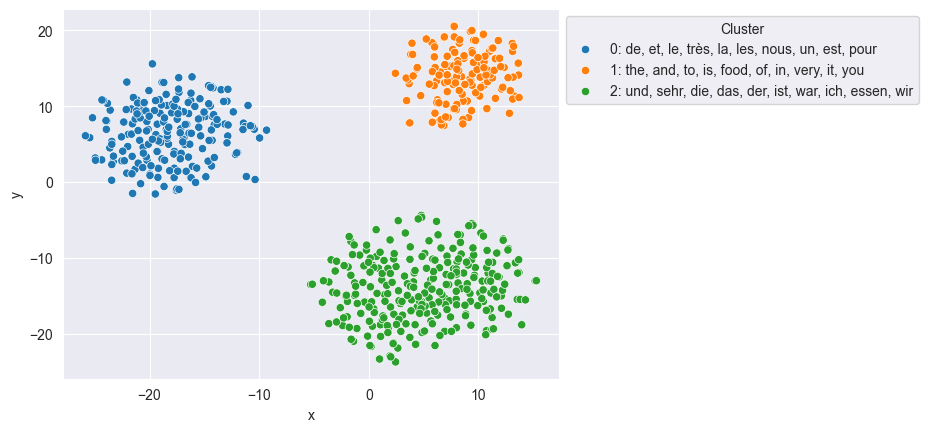

In [15]:
clusters = DBSCAN(eps=5, min_samples=10).fit(embeddings)
labels = clusters.labels_

df["cluster"] = labels

top_terms = {}
for index, label in enumerate(set(labels)):
    all_text = ' '.join(df[df["cluster"] == label]["review_text"])
    top_terms[index] = get_top_terms(all_text, vectorizer)

plot_data = []
for embedding, cluster_id, sentiment in zip(embeddings, labels, df["sentiment"]):
    
    # Cluster ID only:
    label = cluster_id
    
    # Cluster ID + top cluster terms
    label = "{}: {}".format((cluster_id), top_terms[cluster_id])
    
    # Sentiment
    # label = sentiment
    
    plot_data.append({"Cluster": label, "x": embedding[0], "y": embedding[1]})
plot_data_df = pd.DataFrame(plot_data)

tsne_plot = sns.scatterplot(
    x="x", y="y",
    hue="Cluster",
    data=plot_data_df,
    legend="full",
)
sns.move_legend(tsne_plot, "upper left", bbox_to_anchor=(1, 1))